# Analysis

In [1]:
! nvidia-smi

Sun Apr 30 03:46:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Env prep

In [32]:
! pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [40]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Cuda available?  True
Found GPU at: /device:GPU:0


## Data Overview

### Full Data (with all meta-data)

In [3]:
data = pd.read_csv('data.csv')
data

,author_id,tweet,annotator_0,annotator_1,annotator_2,label,like_count,quote_count,reply_count,retweet_count,source,COVID_HATE_BERT_PREDS,CARDIFFNLP_ROBERTA_PREDS,hateXplain_PREDS,COVID_HATE_BERT_PREDS_bin,hateXplain_PREDS_bin,voting_results
0,216712704,So Sad ! China Evicts Africans from their Home...,0,0,0,0,0,0,0,0,Twitter for Android,0,1,0,0,1,1
1,1145106102360649728,This bullshit has gone on long enough ! \nThat...,1,1,1,1,4,0,1,2,Twitter for Android,2,1,2,1,0,1
2,213827781,Chinese should have invented a sexual intercou...,1,1,1,1,1,0,0,0,Twitter for Android,2,1,1,1,0,1
3,1201595808564600832,Stop torturing and killing and eating #dogs an...,1,1,1,1,0,0,0,0,Twitter for Android,2,0,0,1,1,1
4,2225244115,#China is showing too much aggression. In Galw...,0,0,1,0,19,0,0,2,Twitter for Android,2,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,4223711369,"#CHINA =PAPER TIGER, THEY RELY ON OUR INFLATED...",1,0,0,0,0,0,0,0,unk,2,1,2,1,0,1
2392,1352572483,I am not with these corrupted evil racist terr...,0,0,0,0,0,0,0,1,unk,2,0,0,1,1,1
2393,1016882632896937984,Mofos wanna bend #rules to accommodate their p...,0,0,0,0,91,0,1,6,unk,2,1,1,1,0,1
2394,1399696921556566016,#TAIWAN #CHINA #PELOSI #XI ALL COMPANIES IN TA...,0,0,0,0,1,0,0,0,unk,2,1,1,1,0,1


### Lean Data (minimum meta-data)

In [4]:
data = pd.read_csv('min_data.csv')
data

,author_id,tweet,annotator_0,annotator_1,annotator_2,label
0,216712704,So Sad ! China Evicts Africans from their Home...,0,0,0,0
1,1145106102360649728,This bullshit has gone on long enough ! \nThat...,1,1,1,1
2,213827781,Chinese should have invented a sexual intercou...,1,1,1,1
3,1201595808564600832,Stop torturing and killing and eating #dogs an...,1,1,1,1
4,2225244115,#China is showing too much aggression. In Galw...,0,0,1,0
...,...,...,...,...,...,...
2391,4223711369,"#CHINA =PAPER TIGER, THEY RELY ON OUR INFLATED...",1,0,0,0
2392,1352572483,I am not with these corrupted evil racist terr...,0,0,0,0
2393,1016882632896937984,Mofos wanna bend #rules to accommodate their p...,0,0,0,0
2394,1399696921556566016,#TAIWAN #CHINA #PELOSI #XI ALL COMPANIES IN TA...,0,0,0,0


In [7]:
data['tweet'][0]

'So Sad ! China Evicts Africans from their Homes Claiming they are Importing Coronavirus into China @MaziNnamdiKanu #China where did Corona virus originated? #China show the world proof of your claim. I say #Notoracist #Free the blacks https://t.co/1XNolmzvdb'

In [7]:
Counter(data['annotator_0'])

Counter({0: 997, 1: 1399})

In [8]:
Counter(data['annotator_1'])

Counter({0: 1158, 1: 1238})

In [9]:
Counter(data['annotator_2'])

Counter({0: 1418, 1: 978})

In [10]:
Counter(data['label'])

Counter({0: 1217, 1: 1179})

#### Inter-annotator Agreement

In [12]:
from nltk import agreement

rater1 = data['annotator_0'].tolist()
rater2 = data['annotator_1'].tolist()
rater3 = data['annotator_2'].tolist()

taskdata=[[0,str(i),str(rater1[i])] for i in range(0,len(rater1))]+[[1,str(i),str(rater2[i])] for i in range(0,len(rater2))]+[[2,str(i),str(rater3[i])] for i in range(0,len(rater3))]
ratingtask = agreement.AnnotationTask(data=taskdata)
print("kappa " +str(ratingtask.kappa()))
print("fleiss " + str(ratingtask.multi_kappa()))
print("alpha " +str(ratingtask.alpha()))
print("scotts " + str(ratingtask.pi()))

kappa 0.408282641917973
fleiss 0.4074148989378917
alpha 0.4012871238453145
scotts 0.40120381886741624


In [13]:
import itertools
from sklearn.metrics import cohen_kappa_score
import numpy as np

raters = [rater1, rater2, rater3]

d = np.zeros((len(raters), len(raters)))
# Calculate cohen_kappa_score for every combination of raters
# Combinations are only calculated j -> k, but not k -> j, which are equal
# So not all places in the matrix are filled.
for j, k in list(itertools.combinations(range(len(raters)), r=2)):
    d[j, k] = cohen_kappa_score(raters[j], raters[k])

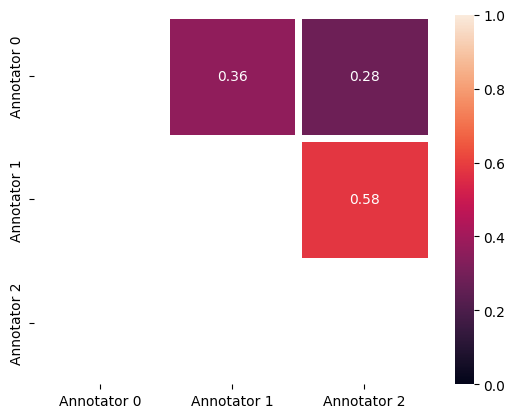

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(
    d, 
    mask=np.tri(len(raters)),
    annot=True, linewidths=5,
    vmin=0, vmax=1,
    xticklabels=[f"Annotator {k}" for k in range(len(raters))],
    yticklabels=[f"Annotator {k }" for k in range(len(raters))],
)
plt.show()

#### Token Counter

In [17]:
import nltk

token_counts = []
tweets = data['tweet']
for tweet in tweets:
  token_counts.append(len(nltk.word_tokenize(tweet)))

In [18]:
max(token_counts)

96

In [19]:
min(token_counts)

3

In [20]:
from statistics import mean
mean(token_counts)

43.90567612687813

Text(0, 0.5, 'Number of tweets')

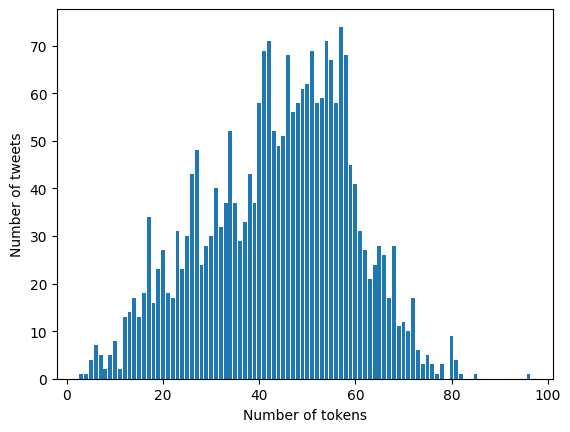

In [25]:
import collections
import matplotlib.pyplot as plt
w = collections.Counter(token_counts)
plt.bar(w.keys(), w.values())
plt.xlabel('Number of tokens')
plt.ylabel('Number of tweets')

## Train/dev/test split

In [5]:
from sklearn.model_selection import train_test_split

x = data['tweet'].to_numpy()
y = data['label'].to_numpy()

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, stratify=y, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size = 0.2,train_size =0.8)

In [6]:
train_df = pd.DataFrame({'tweet':x_train, 'label': y_train})
val_df = pd.DataFrame({'tweet':x_val, 'label': y_val})
test_df = pd.DataFrame({'tweet':x_test, 'label': y_test})

In [7]:
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

## Baselines

#### Data preprocessing

In [33]:
# Preprocess tweets (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

train_df['tweet'] = train_df['tweet'].apply(preprocess)
val_df['tweet'] = val_df['tweet'].apply(preprocess)
test_df['tweet'] = test_df['tweet'].apply(preprocess)

In [36]:
# append val to train for simpletransformers
train_df = train_df.append(val_df, ignore_index=True)
train_df

<ipython-input-36-3d6dc866278c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(val_df, ignore_index=True)


,tweet,label
0,Daily reminder: #china is the cancer on the bo...,1
1,can you produce better vaginas than the americ...,0
2,Last year how relentlessly China tried to push...,0
3,This is how #Chinese corrupted companies r kil...,1
4,"First, China practiced population control on i...",1
...,...,...
1911,#Pakistan #ISI made #Pashtons their slaves las...,0
1912,pootin is a watery turd nugget and the ccp are...,0
1913,My mother was over being #Lao being blame resp...,0
1914,#BoycottChina anything and everything from #c...,1


### BERT

In [56]:
bert_model_args = ClassificationArgs(num_train_epochs=11, 
                                      no_save=True, 
                                      no_cache=True, 
                                      max_seq_length=500,
                                      overwrite_output_dir=True)
bert_model = ClassificationModel("bert", 
                                  'bert-base-cased', 
                                  args = bert_model_args, 
                                  use_cuda=cuda_available)
# train model
bert_model.train_model(train_df[['tweet', 'label']])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1916 [00:00<?, ?it/s]

Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 0 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 1 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 2 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 3 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 4 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 5 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 6 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 7 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 8 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 9 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 10 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

(2640, 0.15371407415492064)

In [58]:
bert_preds, _ = bert_model.predict(test_df['tweet'].tolist())

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [59]:
Counter(bert_preds)

Counter({0: 210, 1: 270})

In [60]:
f1 = f1_score(test_df['label'].tolist(), bert_preds)
precision = precision_score(test_df['label'].tolist(), bert_preds)
recall = recall_score(test_df['label'].tolist(), bert_preds)
print(f'f1: {f1}')
print(f"precision: {precision}")
print(f'recall: {recall}')

f1: 0.7984189723320158
precision: 0.7481481481481481
recall: 0.8559322033898306


### RoBERTa

In [41]:
roberta_model_args = ClassificationArgs(num_train_epochs=11, 
                                      no_save=True, 
                                      no_cache=True, 
                                      max_seq_length=500,
                                      overwrite_output_dir=True)
roberta_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = roberta_model_args, 
                                  use_cuda=cuda_available)
# train model
roberta_model.train_model(train_df[['tweet', 'label']])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1916 [00:00<?, ?it/s]

Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 0 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 1 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 2 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 3 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 4 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 5 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 6 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 7 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 8 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 9 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 10 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

(2640, 0.18859920860691504)

In [43]:
roberta_preds, _ = roberta_model.predict(test_df['tweet'].tolist())

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [57]:
Counter(roberta_preds)

Counter({0: 232, 1: 248})

In [50]:
# target_names = ['class 0', 'class 1']
# print(classification_report(test_df['label'].tolist(), roberta_preds, target_names=target_names))

In [54]:
f1 = f1_score(test_df['label'].tolist(), roberta_preds)
precision = precision_score(test_df['label'].tolist(), roberta_preds)
recall = recall_score(test_df['label'].tolist(), roberta_preds)
print(f'f1: {f1}')
print(f"precision: {precision}")
print(f'recall: {recall}')

f1: 0.7975206611570249
precision: 0.7782258064516129
recall: 0.8177966101694916


### Twitter-RoBERTa

In [62]:
twitter_roberta_model_args = ClassificationArgs(num_train_epochs=11, 
                                      no_save=True, 
                                      no_cache=True, 
                                      max_seq_length=500,
                                      overwrite_output_dir=True)
twitter_roberta_model = ClassificationModel("roberta", 
                                  'cardiffnlp/twitter-roberta-base', 
                                  args = twitter_roberta_model_args, 
                                  use_cuda=cuda_available)
# train model
twitter_roberta_model.train_model(train_df[['tweet', 'label']])

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1916 [00:00<?, ?it/s]

Epoch:   0%|          | 0/11 [00:00<?, ?it/s]

Running Epoch 0 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 1 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 2 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 3 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 4 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 5 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 6 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 7 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 8 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 9 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 10 of 11:   0%|          | 0/240 [00:00<?, ?it/s]

(2640, 0.1417407983857574)

In [63]:
twitter_roberta_preds, _ = twitter_roberta_model.predict(test_df['tweet'].tolist())

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [65]:
Counter(twitter_roberta_preds)

Counter({0: 225, 1: 255})

In [64]:
f1 = f1_score(test_df['label'].tolist(), twitter_roberta_preds)
precision = precision_score(test_df['label'].tolist(), twitter_roberta_preds)
recall = recall_score(test_df['label'].tolist(), twitter_roberta_preds)
print(f'f1: {f1}')
print(f"precision: {precision}")
print(f'recall: {recall}')

f1: 0.8268839103869653
precision: 0.796078431372549
recall: 0.8601694915254238


### BERTweet

In [71]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

In [70]:
# bertweet_model_args = ClassificationArgs(num_train_epochs=11, 
#                                       no_save=True, 
#                                       no_cache=True, 
#                                       max_seq_length=500,
#                                       overwrite_output_dir=True)
# bertweet_model = ClassificationModel("roberta", 
#                                   'vinai/bertweet-base', 
#                                   args = bertweet_model_args, 
#                                   use_cuda=cuda_available)
# # train model
# bertweet_model.train_model(train_df[['tweet', 'label']])